In [1]:
import pandas as pd
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as opt
from ipywidgets import interact, widgets, Layout
import sqlalchemy

%matplotlib inline


In [42]:
%%time
os.chdir(r'e:\FOX_EXPORT\АКС-МОКШ\16.02.2022 14.05.12')
df=pd.read_excel('Свод.xlsx', usecols='B:O')

Wall time: 11.9 s


In [45]:
df.columns

Index(['№ скваж', 'Признак дубля', 'Дата', 'Горизонт',
       'Кол-во часов экспл всего по доб. скваж',
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3', 'в том числе тех.воды, т',
       'в том числе тех.воды, м3', 'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3'],
      dtype='object')

In [3]:
engine = sqlalchemy.create_engine('sqlite:///C:/aiom/OUT/02.03.2021 12.28.25/ROMA.db')
query = f'select* from wells where DAT>"2010-01-01"'
df=pd.read_sql(query, engine, parse_dates=['DAT'])

In [39]:
names = 'Код НГДУ', '№ скваж', '№ скваж с латин литерой', 'Признак дубля', 'Дата','Площадь', 'Горизонт', 'Кол-во часов экспл всего по доб. скваж',\
'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т', 'Добыча воды за мес по скважине, м3', \
'в том числе тех.воды, т', 'в том числе тех.воды, м3', 'Кол-во часов работы всего по нагн. скваж', \
'Общая закачка всего по скваж за мес, м3', 'Технологическая закачка всего по скваж за мес, м3', 'База'


In [41]:
df.drop(columns='index', inplace=True)
df.columns=names

KeyError: "['index'] not found in axis"

In [43]:
df['№ скваж'] = df['№ скваж с латин литерой']
df.drop(columns=df.loc[:,'Технологическая закачка всего по скваж за мес, м3':].columns, inplace=True)

In [7]:
df.columns

Index(['Код НГДУ', '№ скваж', '№ скваж с латин литерой', 'Признак дубля',
       'Дата', 'Площадь', 'Горизонт', 'Кол-во часов экспл всего по доб. скваж',
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3', 'в том числе тех.воды, т',
       'в том числе тех.воды, м3', 'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3'],
      dtype='object')

In [8]:
df.drop(columns='Признак дубля', inplace=True)

In [9]:
df.drop(index=df[df['Кол-во часов экспл всего по доб. скваж']==0].index, inplace=True)

# определяем год ввода скважин в эксплуатацию

In [17]:
df['Год']=df['Дата'].dt.year

In [18]:
def drill_year (df):
    df['Год запуска'] = df['Год'].min()
    return df

In [19]:
df=pd.DataFrame(df.groupby(by='№ скваж').apply(drill_year))

In [20]:
df.drop(columns=['в том числе тех.воды, т','в том числе тех.воды, м3'], inplace=True)

In [21]:
coll=df.columns

In [22]:
df['№ скваж'] = df['№ скваж'].astype('str')

### выбираем нужный горизонт для анализа

In [23]:
w = widgets.SelectMultiple(options = list(df['Горизонт'].unique()))
w

SelectMultiple(options=(476, 480, 444, 450, 443, 475), value=())

In [24]:
df = df.loc[df['Горизонт'].isin(w.value)]

In [25]:
df['Горизонт'] = df['Горизонт'].astype('int')

### или суммируем показатели по горизонтам, если есть необходимость

In [30]:
f = {'Горизонт':['mean'], 
     'Кол-во часов экспл всего по доб. скваж':['max'],
     'Добыча нефти за мес по скваж, т':['sum'], 
     'Добыча воды за мес по скваж, т':['sum'],
     'Добыча воды за мес по скважине, м3':['sum'],
    'Кол-во часов работы всего по нагн. скваж':['max'],
     'Общая закачка всего по скваж за мес, м3':['sum'],
    'Год запуска':['min']}

In [31]:
df = pd.DataFrame(df.groupby(['№ скваж', 'Дата'])['Горизонт', 'Кол-во часов экспл всего по доб. скваж',\
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3',
       'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3', 'Год запуска'].agg(f))
df = df.reset_index()

<ipython-input-31-3bbd0b0ffdd6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = pd.DataFrame(df.groupby(['№ скваж', 'Дата'])['Горизонт', 'Кол-во часов экспл всего по доб. скваж',\


TypeError: other must be a MultiIndex or a list of tuples

In [32]:
df.columns=coll.drop(['Код НГДУ', 'Год', '№ скваж с латин литерой', 'Площадь'])

KeyError: "['Код НГДУ' 'Площадь'] not found in axis"

In [29]:
df.columns

MultiIndex([(                                 '№ скваж',     ''),
            (                                    'Дата',     ''),
            (                                'Горизонт', 'mean'),
            (  'Кол-во часов экспл всего по доб. скваж',  'max'),
            (         'Добыча нефти за мес по скваж, т',  'sum'),
            (          'Добыча воды за мес по скваж, т',  'sum'),
            (      'Добыча воды за мес по скважине, м3',  'sum'),
            ('Кол-во часов работы всего по нагн. скваж',  'max'),
            ( 'Общая закачка всего по скваж за мес, м3',  'sum'),
            (                             'Год запуска',  'min')],
           )

In [22]:
coll

Index(['Код НГДУ', '№ скваж', '№ скваж с латин литерой', 'Дата', 'Площадь',
       'Горизонт', 'Кол-во часов экспл всего по доб. скваж',
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3',
       'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3', 'Год', 'Год запуска'],
      dtype='object')

# Добавляем необходимые колонки 
### - дебит нефти
### - дебит жидкости
### -месяцы работы

In [23]:
df['q_oil']=df['Добыча нефти за мес по скваж, т']/df['Кол-во часов экспл всего по доб. скваж']*24

In [24]:
df['q_liq']=(df['Добыча нефти за мес по скваж, т']+df['Добыча воды за мес по скваж, т'])/df['Кол-во часов экспл всего по доб. скваж']*24

In [25]:
df['wct']=(df['q_liq']-df['q_oil'])/df['q_liq']*100

### Вспомогательные функции. Руками не трогать!

In [26]:

def work_day (df):
    df['Day'] = df['Дата']-df['Дата'].min()
    return df

def work_month (df):
    df['Month'] = np.linspace(1, len(df), len(df))
    return df

def first_deb (df, x=3):
    df['qo'] = df['Добыча нефти за мес по скваж, т'].head(x).sum()/df['Кол-во часов экспл всего по доб. скваж'].head(x).sum()*24
    df['ql'] = (df['Добыча нефти за мес по скваж, т'].head(x).sum()+df['Добыча воды за мес по скваж, т'].head(x).sum())/df['Кол-во часов экспл всего по доб. скваж'].head(x).sum()*24
    return df

def cummulitive (df):
    df['summoil'] = df['Добыча нефти за мес по скваж, т'].cumsum()
    df['summwat'] = df['Добыча нефти за мес по скваж, т'].cumsum()
    df['summlik'] = df['summoil']+df['summwat']
    return df

def Kpad (df):
    df['kpad'] = df['q_oil']/df['q_oil'].shift(1)

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def smoothing_data(smoth_list, null_needs, frame, smoth_alg=exponential_smoothing, smoth_strench=0.1):
    for i in smoth_list:
        name='S'+i
        frame[name] = smoth_alg(frame[i], smoth_strench)
        if i in null_needs:
            frame[name]=frame[i].where(frame[i]==0, frame[name])
        else:
            continue

In [27]:
def well_graph(wellname, x, y, add, save, graph_type):
    fig=plt.figure(figsize=(15, 8))
    if add == True:
        for wells in frame['№ скваж'].unique():
            plt.plot(frame.loc[frame['№ скваж']==wells, 'Month'], frame.loc[frame['№ скваж']==wells, graph_type], 
                     color='grey', alpha=0.5)
    plt.plot(frame.groupby('Month')[graph_type].median().index, frame.groupby('Month')[graph_type].median(), color='red', linewidth = 4, 
             label = 'Медианный профиль добычи', alpha=0.5)
    #plt.plot(frame.groupby('Month')['q_oil'].mean().index, frame.groupby('Month')['q_oil'].quantile(q=0.75),color='green', linewidth = 4, alpha=0.5)
    #plt.plot(frame.groupby('Month')['q_oil'].mean().index, frame.groupby('Month')['q_oil'].quantile(q=0.25), color='black', linewidth = 4, alpha=0.5)
    plt.plot(df.loc[df['№ скваж']==wellname, 'Month'], df.loc[df['№ скваж']==wellname, graph_type], color='black', linewidth = 4, 
             linestyle = '--', alpha=1, label = 'Профиль добычи скважины №'+wellname)
    plt.fill_between(frame.groupby('Month')[graph_type].mean().index, 
                     frame.groupby('Month')[graph_type].median(), 
                     frame.groupby('Month')[graph_type].quantile(q=0.75), color='green', alpha=0.25, 
                    label = 'Верхний интервал') 
    plt.fill_between(frame.groupby('Month')[graph_type].mean().index, 
                     frame.groupby('Month')[graph_type].median(), 
                     frame.groupby('Month')[graph_type].quantile(q=0.25), color='red', alpha=0.25,
                    label = 'Нижний интервал') 
    #plt.plot(xr, yr, color='black', linewidth = 5)
    
    plt.xlabel('Месяц работы', fontsize =20)
    plt.ylabel('Дебит, т/сут', fontsize =20)
    plt.ylim(0, y)
    plt.xlim(1, x)
    plt.grid(True)
    plt.legend()
    if save == True:
        plt.savefig('type_well{0}.png'.format(wellname), bbox_inches='tight', dpi=600)

In [28]:
def exporter(hyperbolic):
    """выгружает данные по работе типовой скважины"""
    prognoz = pd.DataFrame(data=[np.arange(1,181,1),hyperbolic])
    prognoz=prognoz.T
    prognoz.columns = ['Month', 'q_oil']
    prognoz['Month_oil']=prognoz['q_oil']*28
    prognoz['sum']=prognoz['Month_oil'].cumsum()
    Kpad(prognoz)
    return prognoz.T.to_excel('Type.xlsx')

In [29]:
df=pd.DataFrame(df.groupby(by='№ скваж').apply(work_month))

In [30]:
df=pd.DataFrame(df.groupby(by='№ скваж').apply(work_day))

In [31]:
df=pd.DataFrame(df.groupby(by='№ скваж').apply(first_deb))

In [32]:
df=pd.DataFrame(df.groupby(by='№ скваж').apply(cummulitive))

# Блок фильтрации данных для дальнейшей обработки

### Анализ данных по количеству и входным дебитам. 
### Выбери период для проведения оценки

In [33]:
yearlist=list(df['Год запуска'].sort_values().unique())
w = widgets.SelectionRangeSlider(options=yearlist, description = 'годы для анализа',  layout=Layout(width='100%', height='80px'))
w

SelectionRangeSlider(description='годы для анализа', index=(0, 0), layout=Layout(height='80px', width='100%'),…

In [34]:
frame=df[(df['Год запуска']>=w.value[0])&(df['qo']>0)&(df['Год запуска']<=w.value[1])&
        (~(df['№ скваж'].str.contains('.*G'))|\
        (~df['№ скваж'].str.contains('.*Gz')))]

In [35]:
temp = frame.groupby(by='№ скваж')['Год запуска'].mean().reset_index()

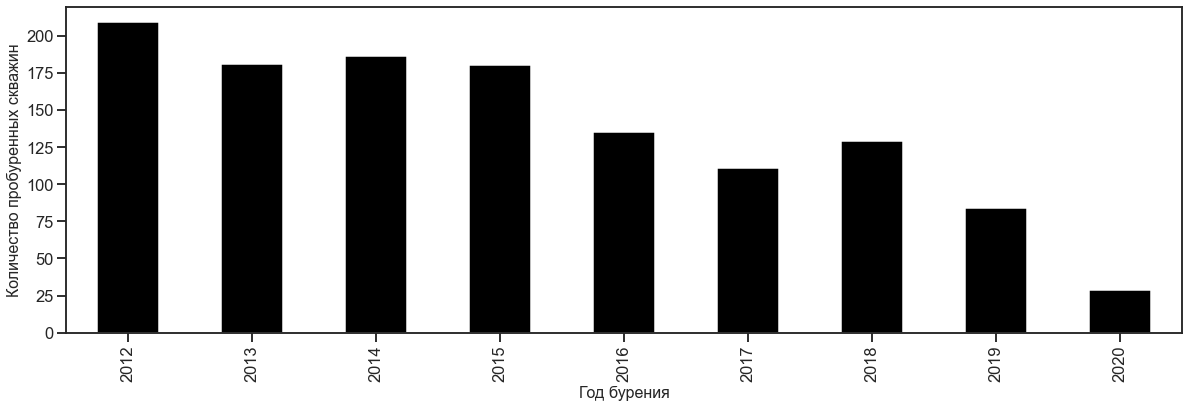

In [36]:
sns.set(style="ticks", palette="pastel")
sns.set_context("talk")

temp['Год запуска'].value_counts().sort_index().plot(kind='bar', color='black', figsize=(20, 6))
plt.xlabel('Год бурения', fontsize=16)
plt.ylabel('Количество пробуренных скважин', fontsize=16)
plt.savefig('count.png', bbox_inches='tight', dpi=600);

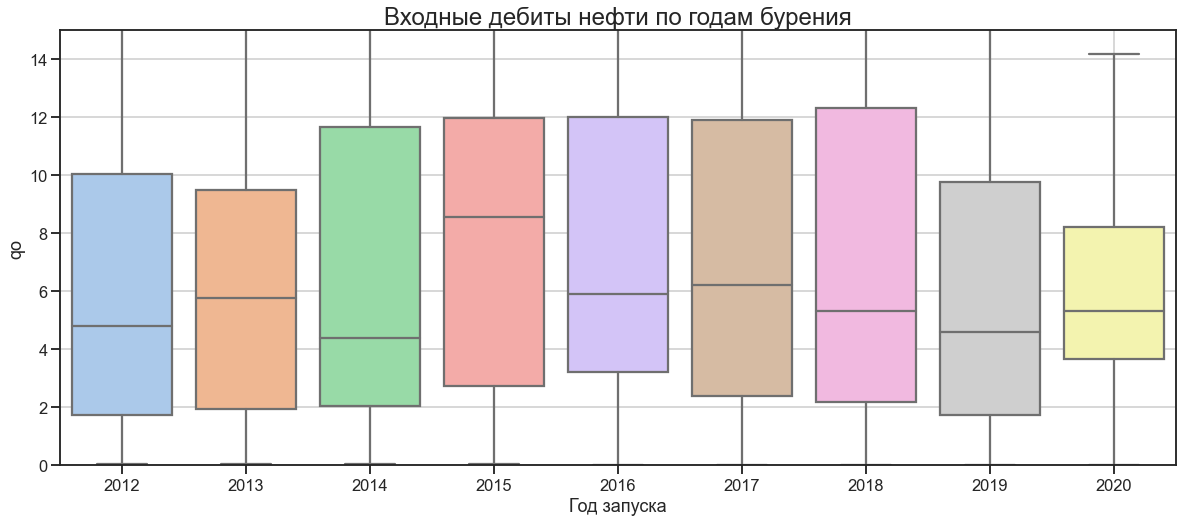

In [37]:
fig,ax=plt.subplots(figsize=(20, 8))
sns.set(style="ticks", palette="pastel")
sns.set_context("talk")
sns.boxplot(x='Год запуска', y='qo', data=frame)
plt.title('Входные дебиты нефти по годам бурения', fontsize=24);
ax.set_ylim(top=15, bottom=0)
ax.grid(True)
plt.savefig('Init_oil.png', bbox_inches='tight', dpi=600);

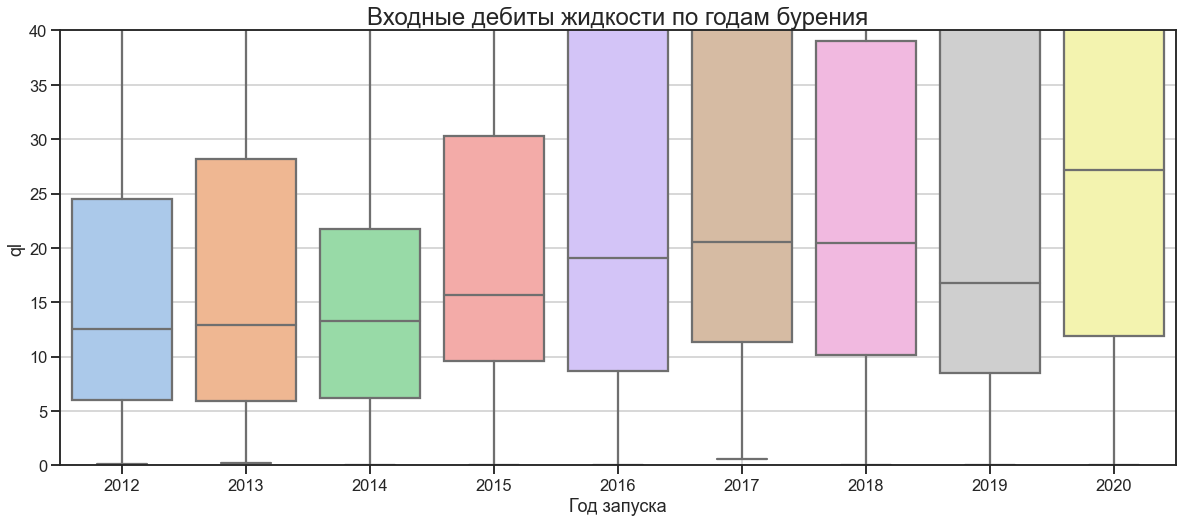

In [38]:
fig,ax=plt.subplots(figsize=(20, 8))
sns.set(style="ticks", palette="pastel")
sns.set_context("talk")
sns.boxplot(x='Год запуска', y='ql', data=frame);
ax.set_ylim(top=40, bottom=0)
plt.title('Входные дебиты жидкости по годам бурения', fontsize=24);

ax.grid(True)
plt.savefig('Init_lik.png', bbox_inches='tight', dpi=600);

In [58]:
frame.loc[frame['Month']==1].groupby('Год запуска')['qo'].describe().to_excel('Describe_oil.xlsx')
frame.loc[frame['Month']==1].groupby('Год запуска')['ql'].describe().to_excel('Describe_lik.xlsx')

### Анализ по накопленной добыче

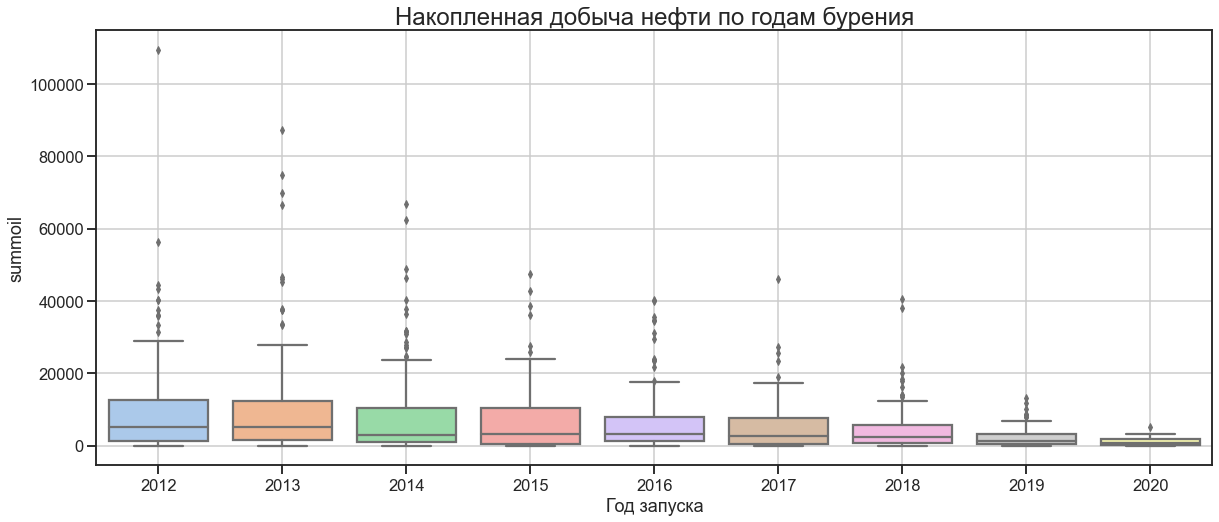

In [39]:
fig,ax=plt.subplots(figsize=(20, 8))
sns.set(style="ticks", palette="pastel")
sns.set_context("talk")
sns.boxplot(x='Год запуска', y='summoil', data = frame.groupby('№ скваж').agg({'Год запуска':'mean', 'summoil':'max'}));
plt.title('Накопленная добыча нефти по годам бурения', fontsize=24)
#plt.axhline(27000, linestyle='--', color='red')
#plt.yscale('log')
#ax.set_ylim(top=80000, bottom=0)
ax.grid(True)
plt.savefig('Init_summ.png', bbox_inches='tight', dpi=600);

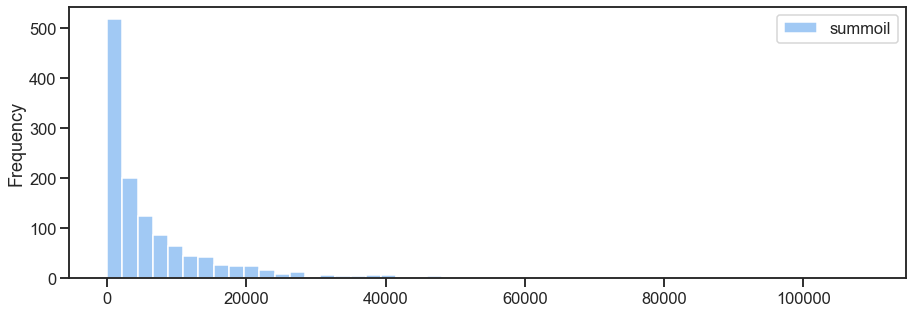

In [40]:
frame.groupby('№ скваж').agg({'summoil':'max'}).plot(kind='hist', bins=50, figsize=(15,5))
#plt.xlim(0, 25000)
#plt.xticks(range(0,25000,10000))
#plt.axvline(5000, linestyle='--', color='red')
plt.savefig('Dis_summ.png', bbox_inches='tight', dpi=600);

In [41]:
nak=frame.groupby('№ скваж').agg({'Год запуска':'mean', 'summoil':'max'})
nak['cat'] = (nak['summoil']>25000)
nak['cat'].mean()

0.05305466237942122

In [42]:
by_year = frame.groupby(['Год запуска','Month'])['q_oil'].mean().reset_index()

## Сглаживание дебитов по годам
### Сделано для того, чтобы оценить профили падения по скважинам разных годов бурения
#### Ауратнее с последними годами, так как может идти рост в связи с недостаточностью статистических данных. Например за 2019 год две скважины с высокими дебитами работали 10 месяцев, низкодебитные не более 7 месяцев. Соответственно с 7 по 10 месяцы будет увеличение среднего дебита в связи с недостаточностью наблюдений. Помни об этом юный падаван

In [43]:
smoothing_data(['q_oil'], null_needs=[], frame = by_year, smoth_alg=exponential_smoothing, smoth_strench=0.8)

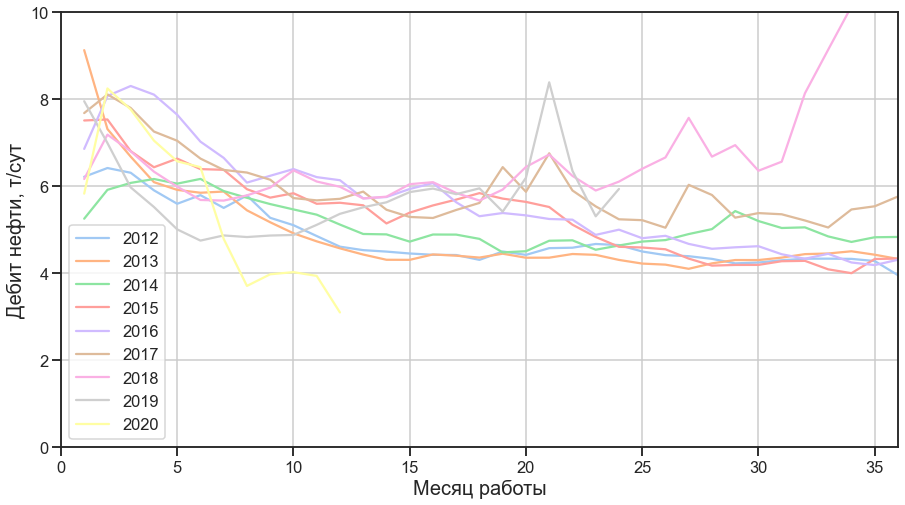

In [45]:
fig=plt.figure(figsize=(15, 8))

for x in by_year['Год запуска'].unique():
    plt.plot(by_year.loc[by_year['Год запуска']==x, 'Month'], by_year.loc[by_year['Год запуска']==x, 'Sq_oil'])
    plt.legend(by_year['Год запуска'].unique())
    plt.grid(True)
plt.xlabel('Месяц работы', fontsize =20)
plt.ylabel('Дебит нефти, т/сут', fontsize =20)
plt.xlim(0, 36)
plt.ylim(0, 10)
plt.savefig('Years_profiles.png', bbox_inches='tight', dpi=600)
plt.show()


### Анализ средней скважины

In [46]:
frame['№ скваж'].unique()

array(['10037', '10098D', '10105', ..., '9918', '9931', '9951D'],
      dtype=object)

In [47]:
frame

,№ скваж,Дата,Горизонт,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Год запуска,q_oil,q_liq,wct,Month,Day,qo,ql,summoil,summwat,summlik
884,10037,2012-07-01,531,466.00,165.000,56.000,48.000,0.0,0.0,2012,8.497854,11.381974,25.339367,1.0,0 days,9.558442,10.987013,165.000,165.000,330.000
885,10037,2012-08-01,531,663.00,278.000,20.000,17.000,0.0,0.0,2012,10.063348,10.787330,6.711409,2.0,31 days,9.558442,10.987013,443.000,443.000,886.000
886,10037,2012-09-01,531,719.00,293.000,34.000,29.000,0.0,0.0,2012,9.780250,10.915160,10.397554,3.0,62 days,9.558442,10.987013,736.000,736.000,1472.000
887,10037,2012-10-01,531,704.00,296.000,21.000,18.000,0.0,0.0,2012,10.090909,10.806818,6.624606,4.0,92 days,9.558442,10.987013,1032.000,1032.000,2064.000
888,10037,2012-11-01,531,692.00,272.000,45.000,39.000,0.0,0.0,2012,9.433526,10.994220,14.195584,5.0,123 days,9.558442,10.987013,1304.000,1304.000,2608.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884047,9951D,2020-08-01,529,555.00,1.349,2.373,2.008,0.0,0.0,2013,0.058335,0.160951,63.756045,89.0,2769 days,3.798742,5.433962,7375.719,7375.719,14751.438
884048,9951D,2020-09-01,529,716.72,78.172,212.934,180.450,0.0,0.0,2013,2.617658,9.747941,73.146551,90.0,2800 days,3.798742,5.433962,7453.891,7453.891,14907.782
884049,9951D,2020-10-01,529,740.48,75.033,218.521,185.189,0.0,0.0,2013,2.431925,9.514499,74.439796,91.0,2830 days,3.798742,5.433962,7528.924,7528.924,15057.848
884050,9951D,2020-11-01,529,597.22,46.413,146.502,124.156,0.0,0.0,2013,1.865162,7.752520,75.941218,92.0,2861 days,3.798742,5.433962,7575.337,7575.337,15150.674


In [48]:
text =widgets.Textarea(description='№ скважины')
graph_type = widgets.RadioButtons( options={'Дебит нефти, т/сут':'q_oil', 'Дебит жидкости, т/сут':'q_liq', 'WCT':'wct'}, value = 'q_oil')    

x_ax=widgets.FloatSlider(min=0, max=180, value=5, step=1, description  = 'X')
y_ax=widgets.FloatSlider(min=0, max=150, value=5, step=0.5, description  = 'Y')
add= widgets.Checkbox(value=False, description='Добавить профили скважин', disabled=False)
save = widgets.ToggleButton(value=False, description='Сохранить график', disabled=False,
                            button_style='info', # 'success', 'info', 'warning', 'danger' or ''
                            tooltip='Description',
                            icon='check', layout=Layout(width='100%', height='30px'))



In [49]:
out = widgets.interactive_output(well_graph, {'wellname':text, 'x':x_ax, 'y':y_ax, 'add':add, 'save':save, 'graph_type':graph_type})
f = widgets.HBox([text, graph_type])
ax = widgets.HBox([x_ax, y_ax])
w = widgets.VBox([f,ax,add,save])
display(out, w)

Output()

In [50]:
frame[frame['№ скваж']=='29074']

,№ скваж,Дата,Горизонт,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Год запуска,q_oil,q_liq,wct,Month,Day,qo,ql,summoil,summwat,summlik


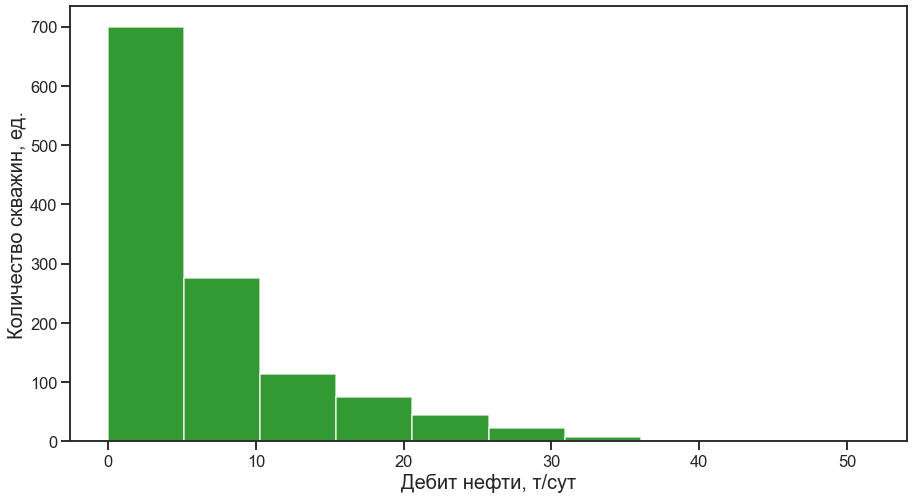

In [51]:
fig=plt.figure(figsize=(15, 8))
plt.hist(frame.groupby('№ скваж')['qo'].min(), color = 'green', alpha = 0.8)
plt.xlabel('Дебит нефти, т/сут', fontsize =20)
plt.ylabel('Количество скважин, ед.', fontsize =20)
plt.axvline(df.loc[df['№ скваж']==text.value, 'qo'].min(), linestyle='--', color='red')
plt.savefig('hist.png', bbox_inches='tight', dpi=600);

In [52]:
typical_well = frame.groupby('Month')['q_oil','q_liq'].median().reset_index()
typical_well['Month_oil']=typical_well['q_oil']*25
typical_well['Month_liq']=typical_well['q_liq']*25
typical_well['sum']=typical_well['Month_oil'].cumsum()
typical_well['sum_liq  ']=typical_well['Month_liq'].cumsum()

typical_well_med = frame.groupby('Month')['q_oil','q_liq'].median().reset_index()
typical_well_med['Month_oil']=typical_well_med['q_oil']*25
typical_well_med['Month_liq']=typical_well_med['q_liq']*25
typical_well_med['sum']=typical_well_med['Month_oil'].cumsum()
typical_well_med['sum_liq']=typical_well_med['Month_liq'].cumsum()

typical_well['№ скваж']='type'

d:\other\my_software\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
d:\other\my_software\python\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


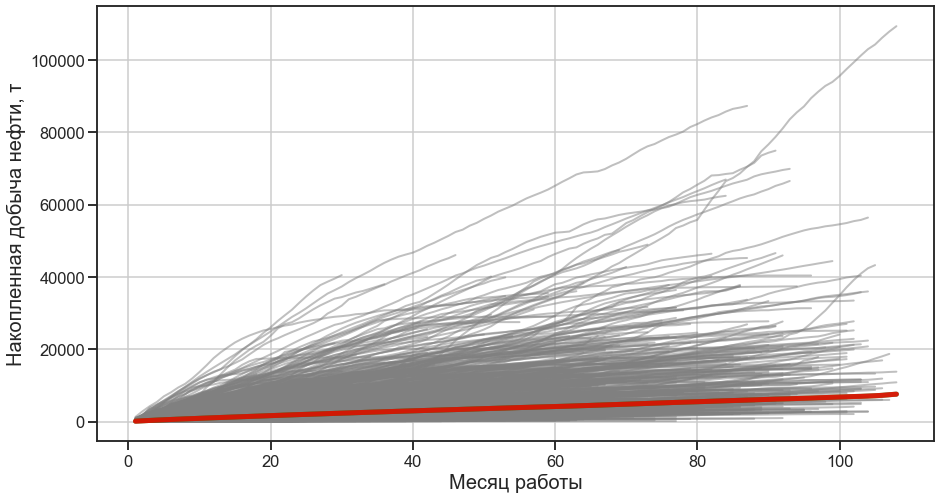

In [53]:
fig=plt.figure(figsize=(15, 8))

for x in frame['№ скваж'].unique():
    plt.plot(frame.loc[frame['№ скваж']==x, 'Month'], frame.loc[frame['№ скваж']==x, 'summoil'], color='grey',linewidth = 2, alpha=0.5)
    #plt.legend(by_year['Год запуска'].unique())
plt.plot(typical_well['Month'], typical_well['sum'], color='green',linewidth = 5, alpha=0.8)   #plt.plot(frame.groupby('Month')['q_oil'].median().index, frame.groupby('Month')['q_oil'].median(), color='red', linewidth = 2, alpha=0.5)
plt.plot(typical_well_med['Month'], typical_well_med['sum'], color='red',linewidth = 5, alpha=0.8)   #plt.plot(frame.groupby('Month')['q_oil'].median().index, frame.groupby('Month')['q_oil'].median(), color='red', linewidth = 2, alpha=0.5)
plt.xlabel('Месяц работы', fontsize =20)
plt.ylabel('Накопленная добыча нефти, т', fontsize =20)
#plt.ylim(0, 25)
#plt.axhline(20000, color='red')
plt.grid(True)
plt.savefig('type_well_summ.png', bbox_inches='tight', dpi=600)
plt.show()

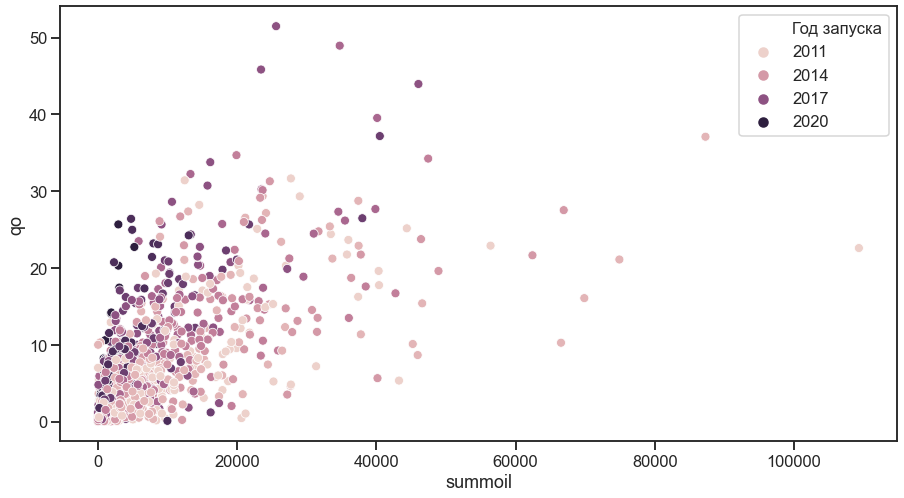

In [54]:
fig=plt.figure(figsize=(15, 8))
sns.scatterplot(x='summoil', y='qo', hue='Год запуска', data = frame.groupby('№ скваж').agg({'Год запуска':'mean','qo':'mean', 'summoil':'max'}))

# Расчет падения уровней добычи

In [55]:
all_wells = pd.concat([frame.loc[:,['№ скваж', 'Month','q_oil']], typical_well.loc[:,['№ скваж', 'Month','q_oil']]])

In [56]:
def coef(well, month, shift_period, frame = all_wells, export=False):
    """Основная функция для нахождения коэффициентов для кривой падения"""
    trening_frame = frame.loc[(frame['№ скваж']==well)&
             (frame['Month']<=month)].reset_index()
    def diff (b, D, q_first):
        '''Расчитывает сумму отконений фактической добычи расчетеной на основании гиперболической кривой падения добычи'''
        time = np.array(range (1,trening_frame.shape[0]-shift_period+1))
        if b<=0:
            return 100000000000000000000
        else:
            eq = q_first/(1+b*D/100*time)**(1/b)
            return float(np.sum((eq - trening_frame.loc[shift_period:,'q_oil'])**2))    
        
    def f(x):
        return diff(*x)
    
    
    x = (0.5, 10, 100)
    D0=opt.minimize(f, x, method='Nelder-Mead')
    q_first= float(D0.x[2])
    b = float(D0.x[0]) 
    D = float(D0.x[1])
    exponent = q_first*np.exp(-D/100*np.array(range (0,181-shift_period)))
    hyperbolic = q_first/(1+b*D/100*np.array(range (0,181-shift_period)))**(1/b)
    harmonik = q_first/(1+D/100*np.array(range (0,181-shift_period)))
    if export == True:
        exporter(hyperbolic)
    return predict_viz(hyperbolic, frame.loc[all_wells['№ скваж']==well], shift_period, month)

In [57]:
def predict_viz(hyperbolic, df_g, first, last):
    """Для визуализации подобранных кривых падения"""
    fig = plt.figure(figsize=(15, 16));
    plt.subplot(211)
    #plt.axis([0, 110, 0, np.max(prodaction)])
    plt.plot(df_g['Month'], df_g['q_oil'], color='grey', alpha = 0.75, label = 'prodaction')
    predict_range=np.arange(first,181,1)
    plt.plot(predict_range, hyperbolic, 'r--', color='blue', alpha = 0.8, label = 'hyperbolic')
    plt.axvspan(first, last, facecolor='#2ca02c', alpha=0.1, label = 'trening_period')
    plt.grid(True)
    #plt.xlim(0, 20)
    plt.xlabel('Месяц работы', fontsize =20)
    plt.ylabel('Дебит нефти, т/сут', fontsize =20)
    plt.legend()
    #plt.text(2, np.max(typical_well['q_oil'])/12, 'b={0}\nD={1}\nq={2}'.format(round(b,2), round(D,2), round(q_first,1)), size = 12);
    #plt.savefig('Arps.png', bbox_inches='tight', dpi=600)
    
    plt.subplot(212)
    #cum_bef_forecast = np.cumsum(df_g['q_oil']*28).shift(2).fillna(0)[first]
    plt.plot(df_g['Month'], np.cumsum(df_g['q_oil']*28), color='grey', alpha = 0.75, label = 'prodaction');
    plt.plot(predict_range, np.cumsum(hyperbolic*28), color='blue', alpha = 0.8, label = 'hyperbolic');
    plt.xlabel('месяц работы', fontsize = 20);
    plt.ylabel('интегральный дебит нефти', fontsize = 20);
    #plt.xlim(0, 20)
    plt.legend()

In [58]:
wich_well = widgets.ToggleButtons(options = {'Типовая скважина':'type', 'Фактическая скважина':text.value})
period=widgets.FloatSlider(min=0, max=50, value=5, step=1, description  = 'Для падения')
shift=widgets.IntSlider(min=1, max=30, value=1, step=1, description  = 'Cдвижка')
save_button=widgets.Checkbox(value=False, description='выгрузка в эксель', disabled=False,
layout=Layout(width='50%', height='30px', border = '1px solid black',font_weight='20'))

In [59]:
trening_frame = all_wells.loc[(all_wells['№ скваж']=='2258')&
             (all_wells['Month']<=8)].reset_index()

In [60]:
 np.cumsum(trening_frame['q_oil']*28).shift(2).fillna(0)

Series([], Name: q_oil, dtype: float64)

In [61]:
out2=widgets.interactive_output(coef, {'well':wich_well, 'month':period, 'shift_period':shift, 'export':save_button})
w=widgets.VBox([period, shift])
w=widgets.HBox([wich_well, text, w])
w=widgets.VBox([w, save_button])
display(w, out2)

Output()

In [56]:
typical_well.to_excel('new.xlsx')